<a href="https://colab.research.google.com/github/ZhihaoDC/TFG/blob/main/source/marvel_social_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup Environment

In [1]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/My Drive/Github/TFG

!git pull https://github.com/ZhihaoDC/TFG

Mounted at /gdrive
/gdrive/My Drive/Github/TFG
From https://github.com/ZhihaoDC/TFG
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


#Import Libraries

In [2]:
!pip install pyvis

In [197]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy
import sys

from collections import deque, Counter

from pyvis.network import Network
import IPython

from tqdm import tqdm

# import matplotlib.colors as mcolors
# import seaborn as sns

# import statistics
# import math
# import itertools
# import re #regular expressions

# import plotly.express as px
# import plotly.figure_factory as ff

#Read files

*   **nodes**: Node name and type.
*   **edges**: Heroes and the comic in which they appear.
*   ***heroes***: Edges between heroes that appear in the same comic.

In [4]:
nodes = pd.read_csv('./datasets/marvel-social-network/nodes.csv') #Node name and type
edges = pd.read_csv('./datasets/marvel-social-network/edges.csv') #Heroes and the comic in which they appear
heroes = pd.read_csv('./datasets/marvel-social-network/hero-network.csv') # Edges between heroes that appear in the same comic

In [5]:
##Show basic info on dataframes:

# nodes.info() #190.090 rows, 2 columns, no null values
# print('\n')
# edges.info() #96.104 rows, 2 columns, no null values
# print('\n')
# heroes.info() #574.467 rows, 2 columns, no null values

In [6]:
##Peek into the dataframes:

# nodes.head(10)
# edges.head(10)
heroes.head(10)

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
5,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
6,"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC"
7,"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA"
8,"STEELE, SIMON/WOLFGA",IRON MAN/TONY STARK
9,"STEELE, SIMON/WOLFGA",IRON MAN IV/JAMES R.


#Data cleaning

In [7]:
#Remove leading and trailing spaces

nodes = nodes.applymap(lambda x: x.strip())
edges = edges.applymap(lambda x: x.strip())
heroes = heroes.applymap(lambda x: x.strip())

#Graph exploration

In [8]:
#Number of times IronMan/TonyStark has appeared in another hero's comic
heroes.loc[ heroes['hero1']=='IRON MAN/TONY STARK' ].shape[0]

5850

In [9]:
# Number of times Spiderman/PeterParker appeared in the same comic as IronMan/TonyStark
heroes.loc[ (heroes['hero1']=='SPIDER-MAN/PETER PAR') & (heroes['hero2']=='IRON MAN/TONY STARK') ].shape[0]

40

In [10]:
# Number of times IronMan/TonyStark appeared in the same comic as Spiderman/PeterParker
heroes.loc[ (heroes['hero1'] == 'IRON MAN/TONY STARK') & (heroes['hero2'] == 'SPIDER-MAN/PETER PAR') ].shape[0]

54

These two values may be different because of the structure of the edgelist. Maybe a relationship of (hero1=Spiderman, hero2=Ironman) indicates an occurence of Spiderman appearing in an Ironman comic.

In [11]:
#Number different comics in which IronMan/TonyStark has appeared in 
ironman_h1 = heroes.loc[heroes['hero1'] == 'IRON MAN/TONY STARK'].drop_duplicates()
ironman_h1.shape[0]

1131

In [12]:
#Number different heroes that have appeared in a IronMan/TonyStark comic
ironman_h2 = heroes.loc[heroes['hero2'] == 'IRON MAN/TONY STARK'].drop_duplicates()
ironman_h2.shape[0]

1106

In [13]:
#Number of times IronMan has been involved in his or other heroes' comics
ironman_merge = pd.merge(ironman_h1, ironman_h2, how='outer', left_on='hero2', right_on='hero1')
ironman_merge.shape[0]

1521

Since we are interested in a non directed graph, we will ignore this fact for the moment

In [14]:
heroes = heroes.drop_duplicates()

#Generate graph

In [15]:
#Generate Undirected Graph structure

graph = nx.from_pandas_edgelist(heroes, source='hero1', target='hero2') 
graph = graph.to_undirected(graph) # Unweighted undirected graph

print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 6421
Number of edges: 167112
Average degree:  52.0517


The graph density of simple graphs is defined to be the ratio of the number of edges ${\displaystyle |E|}$ with respect to the maximum possible edges
For undirected simple graphs, the graph density is:

${\displaystyle D={\frac {|E|}{\binom {|V|}{2}}}={\frac {2|E|}{|V|(|V|-1)}}}$

where E is the number of edges and V is the number of vertices in the graph.

 The maximum number of edges for an undirected graph is ${\displaystyle {\binom {|V|}{2}}={\frac{|V|(|V|-1)}{2}}}$, so the maximal density is 1 (for complete graphs) and the minimal density is 0

In [16]:
def graph_density(n_vertex, n_edges):
  return (2*n_edges / (n_vertex * (n_vertex - 1)) )

In [17]:
density = graph_density(graph.number_of_nodes(), graph.number_of_edges())
print(density)

0.008107742265085212


In [18]:
#Check graph generation

# #Previously seen:
# #Number of times IronMan has been involved in his or other heroes' comics
# ironman_merge = pd.merge(ironman_h1, ironman_h2, how='outer', left_on='hero2', right_on='hero1')
# ironman_merge.shape[0] 
# #Out: 1521

len(list(graph.edges('IRON MAN/TONY STARK')))

1521

In [19]:
graph_nodes = graph.nodes()

In [20]:
graph_edges = graph.edges()

#Generate subgraph

In [21]:
sort_degrees = sorted(list(graph.degree), key= lambda degree: degree[1], reverse= True)
print(sort_degrees)

[('CAPTAIN AMERICA', 1905), ('SPIDER-MAN/PETER PAR', 1737), ('IRON MAN/TONY STARK', 1521), ('THING/BENJAMIN J. GR', 1416), ('MR. FANTASTIC/REED R', 1377), ('WOLVERINE/LOGAN', 1368), ('HUMAN TORCH/JOHNNY S', 1361), ('SCARLET WITCH/WANDA', 1322), ('THOR/DR. DONALD BLAK', 1289), ('BEAST/HENRY &HANK& P', 1265), ('VISION', 1238), ('INVISIBLE WOMAN/SUE', 1236), ('HAWK', 1175), ('WASP/JANET VAN DYNE', 1091), ('ANT-MAN/DR. HENRY J.', 1082), ('CYCLOPS/SCOTT SUMMER', 1078), ('SHE-HULK/JENNIFER WA', 1071), ('STORM/ORORO MUNROE S', 1070), ('ANGEL/WARREN KENNETH', 1070), ('DR. STRANGE/STEPHEN', 1065), ('HULK/DR. ROBERT BRUC', 1055), ('PROFESSOR X/CHARLES', 1032), ('WONDER MAN/SIMON WIL', 1031), ('COLOSSUS II/PETER RA', 1023), ('MARVEL GIRL/JEAN GRE', 1003), ('HERCULES [GREEK GOD]', 989), ('JARVIS, EDWIN', 986), ('SUB-MARINER/NAMOR MA', 979), ('DAREDEVIL/MATT MURDO', 967), ('ICEMAN/ROBERT BOBBY', 944), ('FURY, COL. NICHOLAS', 922), ('JAMESON, J. JONAH', 920), ('BLACK WIDOW/NATASHA', 920), ('QUICKSIL

In [22]:
#Create subgraph with k greatest degree nodes

#Get top k greatest degree nodes
k = 500
greatest_kdeg = []
for node, degree in sort_degrees[:k]:
  greatest_kdeg.append(node)

#Generate subgraph
subgraph = graph.subgraph(greatest_kdeg)
print(nx.info(subgraph))

Name: 
Type: Graph
Number of nodes: 500
Number of edges: 39244
Average degree: 156.9760


In [23]:
# net = Network(notebook=True)
# net.from_nx(subgraph)
# net.repulsion(node_distance=500)
# net.inherit_edge_colors(True)
# net.save_graph('marvel-network-subgraph.html')
# IPython.display.HTML(filename='marvel-network-subgraph.html')

In [24]:
# plt.figure(figsize=(10,10))
# nx.draw_networkx(subgraph)
# plt.show()

#Girvan-Newman

##Shortest paths (BFS)

In [25]:
def shortest_paths(graph, start):
  """ Get all distances from the 'start' node and its path to all nodes in the graph 

      Returns:
          distances: dict(node, shortest_distance_from_start),
          parents: path from node to start as dict(node,predecessor),
          num_shortest_paths: dict(node, num_shortest_paths_from_start)
  """
  #visited list to avoid loops
  visited= []

  #distances from each node to the 'start' node
  distances = dict ( [(node, sys.maxsize) for node in graph.nodes()] ) 

  #predecessors from each node to the 'start' node 
  parents =  dict ( [(node, []) for node in graph.nodes()] )

  #number of shortest paths
  num_shortest_paths = dict ( [(node, []) for node in graph.nodes()] )

  #initialize before loop
  distances[start] = 0
  parents[start] = None
  num_shortest_paths[start] = 1

  #queue data structure for BFS
  queue = deque()
  queue.append(start)

  #mark 'start' as visited
  visited.append(start)

  while (len(queue) != 0):
    visiting = queue.popleft() #visit the first element of the queue (remove it)
    visited.append(visiting) #mark as visited

    for adj in graph.adj[visiting]: #iterate through adjacent nodes
      if (adj not in visited) and (adj not in queue):
        queue.append(adj) #add not visited nodes to queue

      #if 'adj' node has been visited before and has a longer path that using '
      #visiting' as predecessor --> update it (this is the shortest path)

      #if 'adj' node has not been visited before, it will always enter this 'if'
      #because distances are initialized as sys.maxsize
      if (distances[adj] > distances[visiting] + 1): 
        distances[adj] = distances[visiting] + 1
        parents[adj].clear()
        parents[adj].append(visiting)
        num_shortest_paths[adj] = num_shortest_paths[visiting]


      #if 'adj' node has the same distance than 'visiting' + 1, it means we have
      #encountered another shortest path --> add 'visiting' as parent in 
      #the shortest path
      elif (distances[adj] == distances[visiting] + 1):
        parents[adj].append(visiting)
        num_shortest_paths[adj] += num_shortest_paths[visiting]

  #End of algorithm, return results
  return distances, parents, num_shortest_paths

# ### Test code
# distances, parents, num_shortest_paths = shortest_paths(graph, 'CAPTAIN AMERICA')
# distances


##Edge betweenness

In [26]:
def get_edge_betweenness(graph, start):
  """
  Get edge betweenness of all edges given source node 'start' 
  """

  edges_btwnss = dict([(edge, 0) for edge in graph.edges()])
  node_betweenness = dict([(node, 0) for node in graph.nodes()])
  
  distances, parents, num_shortest_paths = shortest_paths(graph, start) 

  #furthest nodes from the selected node
  furthest_nodes = sorted(distances, key=distances.get, reverse=True)

  for node in furthest_nodes:
    if node != start:
      for parent in parents[node]:
        node_betweenness[parent] += (1 + node_betweenness[parent]) / len(parents[node])
        if (node, parent) in edges_btwnss:
          edges_btwnss[node,parent] = (1 + node_betweenness[node]) / num_shortest_paths[node]
        elif (parent,node) in edges_btwnss:
          edges_btwnss[parent,node] = (1 + node_betweenness[node]) / num_shortest_paths[node]

  return edges_btwnss

In [27]:
def get_edge_betweenness(graph, start):
  """
  Get edge betweenness of all edges given source node 'start' 
  """

  edges_btwnss = dict.fromkeys(graph.edges,0)
  node_betweenness = dict.fromkeys(graph.nodes, 0)
  
  distances, parents, num_shortest_paths = shortest_paths(graph, start) 

  #furthest nodes from the selected node
  furthest_nodes = sorted(distances, key=distances.get, reverse=True)

  for node in furthest_nodes:
    if node !=start:
      for parent in parents[node]:
        if node == furthest_nodes[0]:
          node_betweenness.update({parent: 1 / num_shortest_paths[node]}) 
          if (node, parent) in edges_btwnss:
            edges_btwnss.update({(node, parent): 1 / num_shortest_paths[node]})
          elif (parent,node) in edges_btwnss:
             edges_btwnss.update({(parent, node): 1 / num_shortest_paths[node]})

        else:
          btwnnss = (1 + node_betweenness[node]) / num_shortest_paths[node]
          
          if (node, parent) in edges_btwnss:
            edges_btwnss.update({(node, parent):  btwnnss})
            node_betweenness.update({parent: node_betweenness[node] + btwnnss} )

          elif (parent,node) in edges_btwnss:
            edges_btwnss.update({(parent, node): btwnnss})
            node_betweenness.update( {parent: node_betweenness[node] + btwnnss} )

  return edges_btwnss

# get_edge_betweenness(subgraph, 'CAPTAIN AMERICA')

In [28]:
def edge_betweenness(graph):

  btwnss = [0] * len(graph.edges())

  for node in graph.nodes():
    btwnnss_node = get_edge_betweenness(graph, node)
    btwnss = np.add(btwnss, list(btwnnss_node.values())) #here we are using a dict_view instead of original values
    
  #since dict_view has 15 significant ciphers, we will be using 14
  btwnss = [round(score, 14) for score in btwnss]
  btwnss_dict = dict(zip(graph.edges(), btwnss))
  
  return btwnss_dict

In [29]:
# edge_betweenness(subgraph)

##Girvan Newman Algorithm

In [30]:
def Girvan_Newman(graph, k):

  g = graph.copy()

  if (k == 0):
    return g

  for iterations in np.arange(k):
    betweenness = edge_betweenness(g)
    betweenness_values = list(betweenness.values())

    edges_sorted = sorted(betweenness, key=betweenness.get, reverse=True)
    betweenness_values_sorted = sorted(betweenness_values, reverse=True)

    value= betweenness_values_sorted.pop(0)
    edge = edges_sorted.pop(0)

    g.remove_edge(edge[0],edge[1])

  return g
# ###Test Code
# g = Girvan_Newman(subgraph, 30)

In [31]:
# g.remove_edges_from(nx.selfloop_edges(g))
# net = Network(notebook=True)
# net.from_nx(g)
# net.repulsion(node_distance=300)
# net.inherit_edge_colors(True)

# net.save_graph('ex1.html')
IPython.display.HTML(filename='./ex1.html')
# nx.draw_networkx(network)

FileNotFoundError: ignored

In [32]:
karate = nx.karate_club_graph()

In [118]:
result_g = Girvan_Newman(karate,karate.number_of_edges()/3)
# nx.draw_circular(result_g)
S = [list(result_g.subgraph(c).copy().nodes()) for c in nx.connected_components(result_g)]
print(S)

[[0, 1, 3, 7, 12, 13, 17, 19, 21], [9, 2, 27, 28], [4, 5, 6, 10, 16], [32, 33, 8, 14, 15, 18, 20, 22, 23, 24, 25, 29, 30, 31], [11], [26]]


In [164]:
def Girvan_Newman2(graph):

  g = graph.copy()
  k = graph.number_of_edges()
  graphs = []

  for iterations in np.arange(k):
    betweenness = edge_betweenness(g)
    betweenness_values = list(betweenness.values())

    edges_sorted = sorted(betweenness, key=betweenness.get, reverse=True)
    betweenness_values_sorted = sorted(betweenness_values, reverse=True)

    value= betweenness_values_sorted.pop(0)
    edge = edges_sorted.pop(0)

    g.remove_edge(edge[0],edge[1])

    graphs.append(g.copy())

  return graphs
# ###Test Code
# g = Girvan_Newman2(graph)

In [165]:
def Girvan_Newman_dendrogram(graph):
  """
  Returns a dendrogram corresponding with the result of the Girvan-Newman method.
  """
  graphs = Girvan_Newman2(graph)
  dendrogram = []
  for g in graphs:
    dendrogram.append([list(g.subgraph(c).nodes()) for c in nx.connected_components(g)])
  
  return dendrogram

# #Test 
# dd = Girvan_Newman_dendrogram(karate)
# print(dd)
# nx.algorithms.community.quality.modularity(karate, dd[10])

In [243]:
def Girvan_Newman_2004(graph):
  """
  Girvan Newman method proposed in Finding and evaluating community structure in networks
  by M. E. J. Newman and M. Girvan in 2004.
  """
  g = graph.copy()
  k = graph.number_of_edges()
  graphs = []

  for iterations in np.arange(k):
    betweenness = edge_betweenness(g)
    betweenness_values = list(betweenness.values())

    edges_sorted = sorted(betweenness, key=betweenness.get, reverse=True)
    betweenness_values_sorted = sorted(betweenness_values, reverse=True)

    value= betweenness_values_sorted.pop(0)
    edge = edges_sorted.pop(0)

    g.remove_edge(edge[0],edge[1])

    graphs.append(g.copy())

  #Generate dendrogram
  dendrogram = []
  for g in graphs:
    dendrogram.append([list(g.subgraph(c).nodes()) for c in nx.connected_components(g)])
  
  #Select partition with best modularity
  mod_new = 0 
  mod = 0
  threshold = True
  i = 0
  best_mod = 0
  best_partition = None


  for partition in dendrogram:
    mod_new = nx.algorithms.community.quality.modularity(graph, partition)
    if (mod_new > best_mod):
      best_partition = partition
      best_mod = mod_new
    mod = mod_new
  
  return best_partition, best_mod

In [246]:
best_partition, mod = Girvan_Newman_2004(karate)
print(mod)

0.38272518080210394


In [247]:
def dendrogram_to_community(dendrogram):
  community = dict()
  community_num = 0
  for comp in dendrogram:
    for node in comp:
      community.update({node:community_num})
    community_num += 1
  return community

In [238]:
def draw_communities(graph, community):
  """ Draws the graph using colors as community identifier
  """
  pos = nx.spring_layout(graph)
  cmap = cm.get_cmap('viridis', max(community.values()) + 1)
  nx.draw_networkx_nodes(graph, pos, community.keys(), node_size=40,
                        cmap=cmap, node_color=list(community.values()))
  nx.draw_networkx_edges(graph, pos, alpha=0.5)
  plt.show()

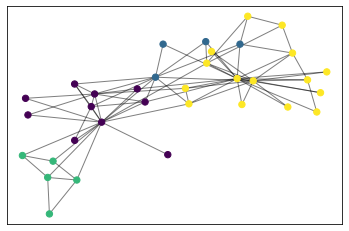

In [248]:
draw_communities(karate, dendrogram_to_community(best_partition))